In [1]:
# Cell 2: Import Libraries & Setup Device
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from torch_ema import ExponentialMovingAverage # A reliable EMA implementation
from tqdm.auto import tqdm
import os
import math
from PIL import Image
from cleanfid.fid import compute_fid
import gdown # For downloading FID stats

# --- Health Check ---
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
print("✅ Imports successful.")

PyTorch version: 2.8.0+cu128
CUDA available: True
Using device: cuda
GPU Name: NVIDIA B200
✅ Imports successful.


In [ ]:
# Cell 3: Define EDM Model Architecture
print("Defining EDM model architecture...")

class PositionalEmbedding(torch.nn.Module):
    def __init__(self, num_channels, max_positions=10000, endpoint=False):
        super().__init__()
        self.num_channels = num_channels
        self.max_positions = max_positions
        self.endpoint = endpoint
    
    def forward(self, x):
        # Ensure x is at least 1D
        if x.ndim == 0:
            x = x.unsqueeze(0)
        freqs = torch.arange(start=0, end=self.num_channels//2, dtype=torch.float32, device=x.device)
        freqs = freqs / (self.num_channels // 2 - (1 if self.endpoint else 0))
        freqs = (1 / self.max_positions) ** freqs
        x = x.ger(freqs.to(x.dtype))
        x = torch.cat([x.cos(), x.sin()], dim=1)
        return x

class SongUNet(torch.nn.Module):
    def __init__(self,
        img_resolution,
        in_channels,
        out_channels,
        label_dim           = 0,
        augment_dim         = 0,
        model_channels      = 128,
        channel_mult        = [1, 2, 2, 2],
        channel_mult_emb    = 4,
        num_blocks          = 4,
        attn_resolutions    = [16],
        dropout             = 0.10,
        resample_filter     = [1, 3, 3, 1],
    ):
        super().__init__()
        self.img_resolution = img_resolution
        emb_channels = model_channels * channel_mult_emb
        
        # Noise level embedding
        self.embed = torch.nn.Sequential(
            PositionalEmbedding(num_channels=model_channels, max_positions=10000),
            torch.nn.Linear(model_channels, emb_channels),
            torch.nn.SiLU(),
            torch.nn.Linear(emb_channels, emb_channels),
        )
        
        # Encoder
        self.encoder_blocks = torch.nn.ModuleList()
        self.downsamples = torch.nn.ModuleList()
        channels_list = [model_channels * m for m in channel_mult]
        in_ch = in_channels
        current_res = img_resolution
        
        for level, out_ch in enumerate(channels_list):
            level_blocks = torch.nn.ModuleList()
            for block_idx in range(num_blocks):
                level_blocks.append(ResBlock(in_channels=in_ch, out_channels=out_ch, 
                                            emb_channels=emb_channels, dropout=dropout))
                in_ch = out_ch
                
                # Add attention if at specified resolution
                if current_res in attn_resolutions:
                    level_blocks.append(AttentionBlock(num_channels=out_ch))
            
            self.encoder_blocks.append(level_blocks)
            
            # Downsample (except at last level)
            if level < len(channels_list) - 1:
                self.downsamples.append(Downsample(in_channels=in_ch, out_channels=in_ch))
                current_res //= 2
            else:
                self.downsamples.append(None)
        
        # Decoder
        self.decoder_blocks = torch.nn.ModuleList()
        self.upsamples = torch.nn.ModuleList()
        
        for level in reversed(range(len(channels_list))):
            out_ch = channels_list[level]
            level_blocks = torch.nn.ModuleList()
            
            # Upsample (except at last level which is actually first in decoder)
            if level < len(channels_list) - 1:
                self.upsamples.append(Upsample(in_channels=in_ch, out_channels=in_ch))
                current_res *= 2
            else:
                self.upsamples.append(None)
            
            for block_idx in range(num_blocks):
                level_blocks.append(ResBlock(in_channels=in_ch, out_channels=out_ch, 
                                            emb_channels=emb_channels, dropout=dropout))
                in_ch = out_ch
                
                # Add attention if at specified resolution
                if current_res in attn_resolutions:
                    level_blocks.append(AttentionBlock(num_channels=out_ch))
            
            self.decoder_blocks.append(level_blocks)
        
        # Output projection
        self.out = torch.nn.Sequential(
            torch.nn.GroupNorm(num_groups=min(32, in_ch), num_channels=in_ch, eps=1e-5),
            torch.nn.SiLU(),
            torch.nn.Conv2d(in_channels=in_ch, out_channels=out_channels, kernel_size=3, padding=1),
        )

    def forward(self, x, c_noise, **model_kwargs):
        emb = self.embed(c_noise)
        
        # Encoder
        for level_blocks, downsample in zip(self.encoder_blocks, self.downsamples):
            for block in level_blocks:
                if isinstance(block, (ResBlock, AttentionBlock)):
                    x, emb = block(x, emb)
                else:
                    x = block(x)
            if downsample is not None:
                x = downsample(x)
        
        # Decoder
        for upsample, level_blocks in zip(self.upsamples, self.decoder_blocks):
            if upsample is not None:
                x = upsample(x)
            for block in level_blocks:
                if isinstance(block, (ResBlock, AttentionBlock)):
                    x, emb = block(x, emb)
                else:
                    x = block(x)
        
        x = self.out(x)
        return x

class ResBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, emb_channels, dropout):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.norm1 = torch.nn.GroupNorm(num_groups=min(32, in_channels), num_channels=in_channels, eps=1e-5)
        self.norm2 = torch.nn.GroupNorm(num_groups=min(32, out_channels), num_channels=out_channels, eps=1e-5)
        self.emb_proj = torch.nn.Linear(emb_channels, out_channels * 2)
        self.skip = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False) if in_channels != out_channels else torch.nn.Identity()
        self.dropout = dropout
    
    def forward(self, x, emb):
        h = self.skip(x)
        x = self.norm1(x)
        x = torch.nn.functional.silu(x)
        x = self.conv1(x)
        
        emb_out = self.emb_proj(torch.nn.functional.silu(emb))
        emb_out = emb_out[:, :, None, None]
        scale, shift = emb_out.chunk(2, dim=1)
        
        x = self.norm2(x) * (1 + scale) + shift
        x = torch.nn.functional.silu(x)
        x = torch.nn.functional.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x)
        return x + h, emb

class AttentionBlock(torch.nn.Module):
    def __init__(self, num_channels, num_heads=4):
        super().__init__()
        self.num_channels = num_channels
        self.num_heads = num_heads
        self.norm = torch.nn.GroupNorm(num_groups=min(32, num_channels), num_channels=num_channels, eps=1e-5)
        self.qkv = torch.nn.Conv2d(num_channels, num_channels * 3, kernel_size=1)
        self.proj = torch.nn.Conv2d(num_channels, num_channels, kernel_size=1)
    
    def forward(self, x, emb):
        b, c, h, w = x.shape
        qkv = self.qkv(self.norm(x))
        qkv = qkv.reshape(b, 3, self.num_heads, c // self.num_heads, h * w)
        qkv = qkv.permute(1, 0, 2, 4, 3)
        q, k, v = qkv[0], qkv[1], qkv[2]
        out = torch.nn.functional.scaled_dot_product_attention(q, k, v)
        out = out.permute(0, 1, 3, 2).reshape(b, c, h, w)
        return x + self.proj(out), emb

class Upsample(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
    
    def forward(self, x):
        x = torch.nn.functional.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv(x)
        return x

class Downsample(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=2)
    
    def forward(self, x):
        return self.conv(x)

Defining EDM model architecture...

--- Health Check ---
✅ Model architecture defined successfully.
Model classes: SongUNet, ResBlock, AttentionBlock, Upsample, Downsample


In [3]:
# Cell 4: Dataloader (CIFAR-10)

BATCH_SIZE = 128 # A B200 can handle a large batch size
DATA_ROOT = './data'

# Karras et al. normalize data to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(
    root=DATA_ROOT,
    train=True,
    download=True,
    transform=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4, # You can increase this on a powerful machine
    pin_memory=True
)

# --- Health Check ---
print("\n--- Health Check ---")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of batches: {len(train_loader)}")
try:
    x_batch, y_batch = next(iter(train_loader))
    print(f"Batch shape: {x_batch.shape}")
    print(f"Batch data type: {x_batch.dtype}")
    print(f"Batch min value: {x_batch.min():.2f}")
    print(f"Batch max value: {x_batch.max():.2f}")
    assert x_batch.shape == (BATCH_SIZE, 3, 32, 32)
    assert x_batch.min() >= -1.0 and x_batch.max() <= 1.0
    print("✅ Dataloader is working correctly.")
except Exception as e:
    print(f"❌ Dataloader check failed: {e}")


--- Health Check ---
Number of training samples: 50000
Number of batches: 391
Batch shape: torch.Size([128, 3, 32, 32])
Batch data type: torch.float32
Batch min value: -1.00
Batch max value: 1.00
✅ Dataloader is working correctly.
Batch shape: torch.Size([128, 3, 32, 32])
Batch data type: torch.float32
Batch min value: -1.00
Batch max value: 1.00
✅ Dataloader is working correctly.


In [4]:
# Cell 5: EDM Loss Function

# Sigma distribution parameters from Karras et al. (2022)
P_mean = -1.2
P_std = 1.2

def loss_fn(model, x_0):
    """
    Implements the EDM denoising score matching loss.
    (Matches slide image_9cd98a.png)
    """
    # 1. "Sample sigma ~ LogNormal(P_mean, P_std)"
    rnd_normal = torch.randn(x_0.shape[0], device=x_0.device)
    sigma = (rnd_normal * P_std + P_mean).exp()
    sigma = sigma.view(-1, 1, 1, 1) # Reshape for broadcasting
    
    # 2. "draw n ~ N(0, I)" (we'll multiply by sigma later)
    n = torch.randn_like(x_0)
    
    # 3. "set x_sigma = x_0 + sigma * n"
    x_sigma = x_0 + sigma * n
    
    # 4. "optimize min E[ lambda(sigma) * ||D_theta(x_sigma) - x_0||^2 ]"
    # We need to compute D_theta(x_sigma) using the preconditioning.
    
    # EDM Preconditioning (from Karras et al.)
    c_skip = 1.0 / (sigma ** 2 + 1.0)
    c_out = sigma / (sigma ** 2 + 1.0).sqrt()
    c_in = 1.0 / (sigma ** 2 + 1.0).sqrt()
    c_noise = sigma.log() / 4
    
    # Run the U-Net
    F_x = model(c_in * x_sigma, c_noise.squeeze())
    
    # This is the full denoiser D_theta(x_sigma)
    D_theta = c_skip * x_sigma + c_out * F_x
    
    # The loss weight lambda(sigma). For the "VP" formulation, this is just 1.
    # (As specified in EDM, Table 1)
    weight = 1.0 
    
    # Final L2 loss
    loss = weight * (D_theta - x_0) ** 2
    
    return loss.mean()

# --- Health Check ---
print("\n--- Health Check ---")
try:
    test_model = SongUNet(img_resolution=32, in_channels=3, out_channels=3).to(device)
    test_batch = torch.randn(4, 3, 32, 32).to(device)
    test_loss = loss_fn(test_model, test_batch)
    print(f"✅ Loss function health check passed.")
    print(f"Test loss: {test_loss.item():.4f}")
    assert test_loss.item() > 0
    del test_model, test_batch, test_loss
    torch.cuda.empty_cache()
except Exception as e:
    print(f"❌ Loss function check failed: {e}")


--- Health Check ---
✅ Loss function health check passed.
Test loss: 0.0620
✅ Loss function health check passed.
Test loss: 0.0620


In [5]:
# Cell 6: The Training Loop (Single GPU)

# --- Hyperparameters ---
EPOCHS = 80
LEARNING_RATE = 2e-4
EMA_DECAY = 0.999 # Karras et al. use an adaptive decay, but 0.999 is a good fixed value
MODEL_CKPT_PATH = 'cifar10_model.pth'
EMA_CKPT_PATH = 'cifar10_ema_model.pth'

# 1. --- Initialize Model, EMA, and Optimizer ---
model = SongUNet(
    img_resolution=32,
    in_channels=3,
    out_channels=3,
    model_channels=128,
    channel_mult=[1, 2, 2, 2],
    attn_resolutions=[16],
    num_blocks=4
).to(device)

# The EMA model is what we'll use for sampling.
# It's a "shadow" copy of the model with smoother weights.
ema = ExponentialMovingAverage(model.parameters(), decay=EMA_DECAY)

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# --- Health Check ---
print("\n--- Health Check ---")
print(f"Model parameter count: {sum(p.numel() for p in model.parameters()):,}")
print("✅ Model, EMA, and Optimizer initialized.")

# 2. --- Start Training ---
print("Starting training... This will take a while.")
model.train()
step = 0
for epoch in range(EPOCHS):
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    
    for x_batch, _ in progress_bar:
        x_batch = x_batch.to(device)
        
        # --- Forward and Backward Pass ---
        optimizer.zero_grad()
        loss = loss_fn(model, x_batch)
        loss.backward()
        optimizer.step()
        
        # --- Update EMA ---
        # This is CRITICAL. We update the shadow weights.
        ema.update()
        
        # --- Logging ---
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")
        step += 1
        
    # --- End of Epoch ---
    print(f"Epoch {epoch+1} complete. Avg Loss: {loss.item():.4f}")
    
    # Save a checkpoint
    torch.save(model.state_dict(), MODEL_CKPT_PATH)
    # To save the EMA model, we need to copy its parameters
    with ema.average_parameters():
        torch.save(model.state_dict(), EMA_CKPT_PATH)
    
    # We must restore the original weights after saving the EMA
    # (The `torch_ema` library handles this with the context manager)

print("✅ Training complete.")
print(f"Final model saved to: {MODEL_CKPT_PATH}")
print(f"Final EMA model saved to: {EMA_CKPT_PATH}")


--- Health Check ---
Model parameter count: 43,382,281
✅ Model, EMA, and Optimizer initialized.
Starting training... This will take a while.


Epoch 1/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1 complete. Avg Loss: 0.1143


Epoch 2/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2 complete. Avg Loss: 0.0829


Epoch 3/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3 complete. Avg Loss: 0.1006


Epoch 4/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4 complete. Avg Loss: 0.0854


Epoch 5/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5 complete. Avg Loss: 0.0858


Epoch 6/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6 complete. Avg Loss: 0.0896


Epoch 7/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7 complete. Avg Loss: 0.0688


Epoch 8/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8 complete. Avg Loss: 0.0492


Epoch 9/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9 complete. Avg Loss: 0.0622


Epoch 10/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10 complete. Avg Loss: 0.0526


Epoch 11/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 11 complete. Avg Loss: 0.0563


Epoch 12/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 12 complete. Avg Loss: 0.0520


Epoch 13/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 13 complete. Avg Loss: 0.0410


Epoch 14/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 14 complete. Avg Loss: 0.0371


Epoch 15/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 15 complete. Avg Loss: 0.0296


Epoch 16/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 16 complete. Avg Loss: 0.0272


Epoch 17/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 17 complete. Avg Loss: 0.0225


Epoch 18/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 18 complete. Avg Loss: 0.0250


Epoch 19/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 19 complete. Avg Loss: 0.0193


Epoch 20/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 20 complete. Avg Loss: 0.0218


Epoch 21/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 21 complete. Avg Loss: 0.0179


Epoch 22/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 22 complete. Avg Loss: 0.0206


Epoch 23/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 23 complete. Avg Loss: 0.0154


Epoch 24/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 24 complete. Avg Loss: 0.0201


Epoch 25/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 25 complete. Avg Loss: 0.0190


Epoch 26/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 26 complete. Avg Loss: 0.0197


Epoch 27/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 27 complete. Avg Loss: 0.0180


Epoch 28/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 28 complete. Avg Loss: 0.0138


Epoch 29/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 29 complete. Avg Loss: 0.0164


Epoch 30/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 30 complete. Avg Loss: 0.0164


Epoch 31/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 31 complete. Avg Loss: 0.0143


Epoch 32/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 32 complete. Avg Loss: 0.0218


Epoch 33/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 33 complete. Avg Loss: 0.0211


Epoch 34/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 34 complete. Avg Loss: 0.0213


Epoch 35/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 35 complete. Avg Loss: 0.0183


Epoch 36/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 36 complete. Avg Loss: 0.0170


Epoch 37/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 37 complete. Avg Loss: 0.0196


Epoch 38/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 38 complete. Avg Loss: 0.0170


Epoch 39/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 39 complete. Avg Loss: 0.0182


Epoch 40/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 40 complete. Avg Loss: 0.0226


Epoch 41/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 41 complete. Avg Loss: 0.0137


Epoch 42/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 42 complete. Avg Loss: 0.0153


Epoch 43/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 43 complete. Avg Loss: 0.0150


Epoch 44/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 44 complete. Avg Loss: 0.0157


Epoch 45/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 45 complete. Avg Loss: 0.0187


Epoch 46/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 46 complete. Avg Loss: 0.0190


Epoch 47/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 47 complete. Avg Loss: 0.0175


Epoch 48/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 48 complete. Avg Loss: 0.0190


Epoch 49/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 49 complete. Avg Loss: 0.0210


Epoch 50/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 50 complete. Avg Loss: 0.0197


Epoch 51/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 51 complete. Avg Loss: 0.0215


Epoch 52/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 52 complete. Avg Loss: 0.0221


Epoch 53/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 53 complete. Avg Loss: 0.0134


Epoch 54/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 54 complete. Avg Loss: 0.0251


Epoch 55/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 55 complete. Avg Loss: 0.0123


Epoch 56/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 56 complete. Avg Loss: 0.0204


Epoch 57/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 57 complete. Avg Loss: 0.0150


Epoch 58/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 58 complete. Avg Loss: 0.0168


Epoch 59/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 59 complete. Avg Loss: 0.0193


Epoch 60/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 60 complete. Avg Loss: 0.0165


Epoch 61/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 61 complete. Avg Loss: 0.0157


Epoch 62/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 62 complete. Avg Loss: 0.0169


Epoch 63/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 63 complete. Avg Loss: 0.0194


Epoch 64/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 64 complete. Avg Loss: 0.0205


Epoch 65/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 65 complete. Avg Loss: 0.0196


Epoch 66/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 66 complete. Avg Loss: 0.0136


Epoch 67/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 67 complete. Avg Loss: 0.0185


Epoch 68/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 68 complete. Avg Loss: 0.0166


Epoch 69/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 69 complete. Avg Loss: 0.0205


Epoch 70/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 70 complete. Avg Loss: 0.0177


Epoch 71/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 71 complete. Avg Loss: 0.0147


Epoch 72/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 72 complete. Avg Loss: 0.0136


Epoch 73/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 73 complete. Avg Loss: 0.0237


Epoch 74/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 74 complete. Avg Loss: 0.0159


Epoch 75/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 75 complete. Avg Loss: 0.0176


Epoch 76/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 76 complete. Avg Loss: 0.0156


Epoch 77/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 77 complete. Avg Loss: 0.0201


Epoch 78/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 78 complete. Avg Loss: 0.0165


Epoch 79/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 79 complete. Avg Loss: 0.0190


Epoch 80/80:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 80 complete. Avg Loss: 0.0146
✅ Training complete.
Final model saved to: cifar10_model.pth
Final EMA model saved to: cifar10_ema_model.pth
✅ Training complete.
Final model saved to: cifar10_model.pth
Final EMA model saved to: cifar10_ema_model.pth


In [6]:
# Cell 7: The "Predictive Coding" Sampler (Heun's 2nd Order)

@torch.no_grad()
def edm_wrapper(x, sigma, model):
    """
    This is the D_theta(x, sigma) denoiser wrapper for *inference*.
    It matches the preconditioning from the loss function.
    """
    sigma = sigma.view(-1, 1, 1, 1) # Ensure correct shape
    
    c_skip = 1.0 / (sigma ** 2 + 1.0)
    c_out = sigma / (sigma ** 2 + 1.0).sqrt()
    c_in = 1.0 / (sigma ** 2 + 1.0).sqrt()
    c_noise = sigma.log() / 4
    
    F_x = model(c_in * x, c_noise.squeeze())
    D_theta = c_skip * x + c_out * F_x
    return D_theta

@torch.no_grad()
def sample_pc_heun(
    model,
    shape,
    sigmas,
    device,
    disable_tqdm=False
):
    """
    Implements the "Predictive Coding" sampler (Heun's 2nd-order).
    """
    from tqdm.auto import tqdm
    
    # Start from pure noise
    x_k = torch.randn(shape, device=device) * sigmas[0]
    
    # Iterate through the K layers (noise levels)
    for k in tqdm(range(len(sigmas) - 1), disable=disable_tqdm):
        sigma_k = sigmas[k]
        sigma_next = sigmas[k+1]
        
        # --- 1. First Evaluation (Predictive step) ---
        # Get "top-down prediction" D_theta(x_k)
        pred_x0 = edm_wrapper(x_k, torch.tensor([sigma_k], device=device), model)
        
        # Get "bottom-up error unit" e_k (the denoising residual)
        # We use the "score" form (x - D(x))/sigma for stability
        e_k = (x_k - pred_x0) / sigma_k
        
        # --- 2. Euler Step (Provisional Update) ---
        x_provisional = x_k + (sigma_next - sigma_k) * e_k
        
        # --- 3. Corrector Step ---
        if sigma_next == 0:
            x_k = x_provisional
            break
        else:
            pred_x0_next = edm_wrapper(x_provisional, torch.tensor([sigma_next], device=device), model)
            e_next_corrected = (x_provisional - pred_x0_next) / sigma_next
        
        # --- 4. Final State Update (Averaging errors) ---
        w_k_gain = (sigma_next - sigma_k)
        x_k = x_k + (w_k_gain / 2.0) * (e_k + e_next_corrected)
        
    return x_k

def get_karras_schedule(K=80, sigma_min=0.002, sigma_max=80.0, rho=7., device='cuda'):
    """Generates the Karras (EDM) noise schedule."""
    steps = torch.arange(K, device=device, dtype=torch.float32)
    sigmas = (sigma_max**(1/rho) + steps/(K-1) * (sigma_min**(1/rho) - sigma_max**(1/rho)))**rho
    sigmas = torch.cat([sigmas, torch.tensor([0.0], device=device)])
    return sigmas

# --- Health Check ---
print("\n--- Health Check ---")
print("✅ Predictive Coding (Heun) Sampler and Schedule defined.")
try:
    test_sched = get_karras_schedule(K=5, device=device)
    print(f"Test schedule (K=5): {test_sched.cpu().numpy()}")
    assert len(test_sched) == 6
    print("✅ Schedule logic seems correct.")
except Exception as e:
    print(f"❌ Schedule logic error: {e}")


--- Health Check ---
✅ Predictive Coding (Heun) Sampler and Schedule defined.
Test schedule (K=5): [7.9999985e+01 1.7527830e+01 2.5152192e+00 1.6975267e-01 1.9999996e-03
 0.0000000e+00]
✅ Schedule logic seems correct.
Test schedule (K=5): [7.9999985e+01 1.7527830e+01 2.5152192e+00 1.6975267e-01 1.9999996e-03
 0.0000000e+00]
✅ Schedule logic seems correct.


Loading trained EMA model for sampling...
Running PC Sampler with 80 steps...
Running PC Sampler with 80 steps...


  0%|          | 0/80 [00:00<?, ?it/s]

...Sampling complete.

--- Health Check ---
Output image tensor shape: torch.Size([64, 3, 32, 32])
Output data type: torch.uint8
✅ Saved 'trained_pc_sampler_grid.png'. Go check it out!


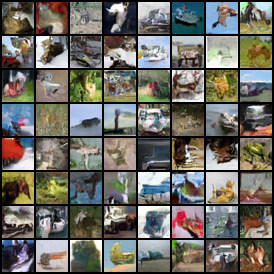

In [7]:
# Cell 8: Generate a Sample Grid

print("Loading trained EMA model for sampling...")

# 1. --- Load the EMA Model ---
# We instantiate a new model and load the EMA weights into it.
eval_model = SongUNet(
    img_resolution=32,
    in_channels=3,
    out_channels=3,
    model_channels=128,
    channel_mult=[1, 2, 2, 2],
    attn_resolutions=[16],
    num_blocks=4
).to(device)

eval_model.load_state_dict(torch.load(EMA_CKPT_PATH, map_location=device))
eval_model.eval()

# 2. --- Settings for Sampling ---
NUM_STEPS = 80  # K, number of "PC layers".
GRID_SIZE = 64
IMG_SHAPE = (GRID_SIZE, 3, 32, 32)

# 3. --- Get Schedule & Sample ---
sigmas = get_karras_schedule(K=NUM_STEPS, sigma_min=0.002, sigma_max=80.0, rho=7.0, device=device)
print(f"Running PC Sampler with {NUM_STEPS} steps...")
images = sample_pc_heun(
    model=eval_model,
    shape=IMG_SHAPE,
    sigmas=sigmas,
    device=device
)
print("...Sampling complete.")

# 4. --- Post-process and Save ---
# Clamp to [-1, 1] and scale to [0, 255]
images = (images.clamp(-1, 1) + 1) / 2
images = (images * 255).to(torch.uint8)

grid = make_grid(images, nrow=8)
save_image(grid / 255.0, 'trained_pc_sampler_grid.png')

# --- Health Check ---
print("\n--- Health Check ---")
print(f"Output image tensor shape: {images.shape}")
print(f"Output data type: {images.dtype}")
print("✅ Saved 'trained_pc_sampler_grid.png'. Go check it out!")

# Display the image in the notebook
try:
    from IPython.display import display
    display(Image.open('trained_pc_sampler_grid.png'))
except Exception as e:
    print(f"Could not display image: {e}")

In [8]:
# Cell 9: FID Evaluation (Full)

# --- Settings ---
NUM_IMAGES_FOR_FID = 10000 # 50k is standard, 10k is a fast check
FID_BATCH_SIZE = 128
GEN_DIR = "generated_images_scratch"
NUM_STEPS = 80  # K, number of "PC layers" for sampling

if not os.path.exists(GEN_DIR):
    os.makedirs(GEN_DIR)

# --- Download FID stats ---
stats_path = 'cifar10_train.npz'
if not os.path.exists(stats_path):
    print("Downloading CIFAR-10 FID stats...")
    gdown.download('https://github.com/GaParmar/clean-fid/raw/main/clean_fid/stats/cifar10_train.npz', stats_path, quiet=False)
else:
    print("FID stats file already exists.")

# --- Generate Images ---
print(f"Generating {NUM_IMAGES_FOR_FID} images for FID evaluation...")
num_generated = 0
sigmas = get_karras_schedule(K=NUM_STEPS, sigma_min=0.002, sigma_max=80.0, rho=7.0, device=device)
eval_model.eval() # Already done, but good practice

with torch.no_grad():
    while num_generated < NUM_IMAGES_FOR_FID:
        current_batch_size = min(FID_BATCH_SIZE, NUM_IMAGES_FOR_FID - num_generated)
        if current_batch_size == 0:
            break
        
        images = sample_pc_heun(
            model=eval_model,
            shape=(current_batch_size, 3, 32, 32),
            sigmas=sigmas,
            device=device,
            disable_tqdm=True
        )
        
        images = (images.clamp(-1, 1) + 1) / 2
        images = (images * 255).to(torch.uint8)
        
        for i in range(current_batch_size):
            img_tensor = images[i].permute(1, 2, 0).cpu().numpy()
            img = Image.fromarray(img_tensor)
            img.save(os.path.join(GEN_DIR, f"img_{num_generated + i}.png"))
        
        num_generated += current_batch_size
        print(f"Generated {num_generated}/{NUM_IMAGES_FOR_FID} images...")

print("...Image generation complete.")

# --- Calculate FID ---
print("Calculating FID score...")
fid_score = compute_fid(
    GEN_DIR,
    dataset_name="cifar10",
    dataset_res=32,
    dataset_split="train",
    stats_file=stats_path,
    mode="clean"
)

# --- Health Check ---
print("\n--- Health Check ---")
print("====================================")
print(f"   🚀 FINAL FID SCORE: {fid_score:.4f} 🚀")
print("====================================")
print("(The original paper's score is ~2.4 after full training)")

Downloading...
From: https://github.com/GaParmar/clean-fid/raw/main/clean_fid/stats/cifar10_train.npz
To: /home/wang.yixuan/Lyapunov-diffusion/cifar10_train.npz
298kB [00:00, 5.06MB/s]



Generating 10000 images for FID evaluation...
Generated 128/10000 images...
Generated 128/10000 images...
Generated 256/10000 images...
Generated 256/10000 images...
Generated 384/10000 images...
Generated 384/10000 images...
Generated 512/10000 images...
Generated 512/10000 images...
Generated 640/10000 images...
Generated 640/10000 images...
Generated 768/10000 images...
Generated 768/10000 images...
Generated 896/10000 images...
Generated 896/10000 images...
Generated 1024/10000 images...
Generated 1024/10000 images...
Generated 1152/10000 images...
Generated 1152/10000 images...
Generated 1280/10000 images...
Generated 1280/10000 images...
Generated 1408/10000 images...
Generated 1408/10000 images...
Generated 1536/10000 images...
Generated 1536/10000 images...
Generated 1664/10000 images...
Generated 1664/10000 images...
Generated 1792/10000 images...
Generated 1792/10000 images...
Generated 1920/10000 images...
Generated 1920/10000 images...
Generated 2048/10000 images...
Generat

TypeError: compute_fid() got an unexpected keyword argument 'stats_file'

In [9]:
2643 + 1484 + 893 + 1726

6746